## Libraries installation

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz
#!pip install bert-tensorflow
#!pip install transformers
#!pip install tf-models-nightly
!pip install tensorflow-text-nightly
!pip install tf-models-official==2.5.0
!pip install tensorflow-text==2.5.0
!pip install tweepy

     |████████████████████████████████| 2.2 MB 4.3 MB/s 
     |████████████████████████████████| 4.9 MB 30.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 44.3 MB/s 
     |████████████████████████████████| 636 kB 49.5 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 237 kB 52.5 MB/s 
     |████████████████████████████████| 1.1 MB 47.2 MB/s 
     |████████████████████████████████| 47.8 MB 62 kB/s 
     |████████████████████████████████| 90 kB 7.5 MB/s 
     |████████████████████████████████| 352 kB 71.5 MB/s 
     |████████████████████████████████| 462 kB 63.1 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=52064c7adce73b6c9d7ac167803a71f32bdf34971ad795618ffffd6f98f44acf
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1

## Loading dataset

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


1 Physical GPUs, 1 Logical GPUs
Version:  2.5.3
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#Importing data from google drive file
from google.colab import drive ##
drive.mount('/content/gdrive') ##

constraint_train_df = pd.read_csv("/content/gdrive/My Drive/Group_Project_530/FakeNews_Dataset/Constraint_Train.csv")
constraint_test_df = pd.read_csv("/content/gdrive/My Drive/Group_Project_530/FakeNews_Dataset/Constraint_Test.csv")
constraint_val_df = pd.read_csv("/content/gdrive/My Drive/Group_Project_530/FakeNews_Dataset/Constraint_Val.csv")

Mounted at /content/gdrive


In [ ]:
#Shuffling train data and dropping id 
constraint_train_df= constraint_train_df.sample(n=len(constraint_train_df), random_state=42)
constraint_train_df= constraint_train_df.reset_index().drop('index', axis =1)   
constraint_train_df.drop(['id'], axis=1, inplace=True)
constraint_train_df.label = constraint_train_df.label.apply(lambda x: 1 if x=='fake' else 0) 

constraint_train_df.head()

,tweet,label
0,"Canada’s top BDSM doctor says wear a mask, lea...",1
1,There are 3 cases considered to have recovered...,0
2,Heard about contact tracing but not sure what ...,0
3,India records its highest single-day increase ...,1
4,Researchers warned of a ticking coronavirus ti...,0


In [ ]:
#Shuffling test data and dropping id 
constraint_val_df= constraint_val_df.sample(n=len(constraint_val_df), random_state=42)
constraint_val_df= constraint_val_df.reset_index().drop('index', axis =1)   
constraint_val_df.drop(['id'], axis=1, inplace=True)
constraint_val_df.label = constraint_val_df.label.apply(lambda x: 1 if x=='fake' else 0) 
constraint_val_df.head()

,tweet,label
0,_New vaccine can help cure coronavirus in thre...,1
1,For a breakdown of cases by states in real tim...,0
2,According to a report by the WHO coronavirus l...,1
3,Focus on good nutrition as a part of self-care...,0
4,Dr. Manish Patil died due to coronavirus in Ma...,1


In [ ]:
#Shuffling test data and dropping id 
constraint_test_df.drop(['id'], axis=1, inplace=True)
constraint_test_df.head()

,tweet
0,Our daily update is published. States reported...
1,Alfalfa is the only cure for COVID-19.
2,President Trump Asked What He Would Do If He W...
3,States reported 630 deaths. We are still seein...
4,This is the sixth time a global health emergen...


In [ ]:
constraint_train_df.label.value_counts()

0    3360
1    3060
Name: label, dtype: int64

In [ ]:
constraint_val_df.label.value_counts()

0    1120
1    1020
Name: label, dtype: int64

In [ ]:
import re, string

def text_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)   

    return text

constraint_train_df.tweet = constraint_train_df.tweet.apply(lambda x: text_cleaning(x))
constraint_train_df.head()

,tweet,label
0,canada’s top bdsm doctor says wear a mask leas...,1
1,there are cases considered to have recovered ...,0
2,heard about contact tracing but not sure what ...,0
3,india records its highest singleday increase o...,1
4,researchers warned of a ticking coronavirus ti...,0


## Bert Implementation

### Model Architecture

In [ ]:
x_train = constraint_train_df.tweet.values
y_train = constraint_train_df.label.values

x_test = constraint_val_df.tweet.values
y_test = constraint_val_df.label.values

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids
      }

  return inputs

In [ ]:
X_train = bert_encode(x_train, tokenizer, 100)
X_test = bert_encode(x_test, tokenizer, 100)

In [ ]:
num_class = 2  
max_seq_length = 100  

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

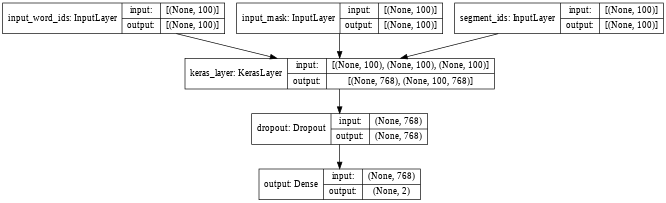

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [ ]:
epochs = 5
batch_size = 16  

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

### Model training

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/5
402/402 [==============================] - 121s 260ms/step - loss: 0.3685 - accuracy: 0.8364 - val_loss: 0.7288 - val_accuracy: 0.7575
Epoch 2/5
402/402 [==============================] - 105s 262ms/step - loss: 0.1950 - accuracy: 0.9375 - val_loss: 0.2368 - val_accuracy: 0.9089
Epoch 3/5
402/402 [==============================] - 104s 258ms/step - loss: 0.1007 - accuracy: 0.9749 - val_loss: 0.3991 - val_accuracy: 0.9075
Epoch 4/5
402/402 [==============================] - 104s 258ms/step - loss: 0.0389 - accuracy: 0.9900 - val_loss: 0.5645 - val_accuracy: 0.8986
Epoch 5/5
402/402 [==============================] - 104s 258ms/step - loss: 0.0178 - accuracy: 0.9960 - val_loss: 0.5550 - val_accuracy: 0.9042


### Evaluation and Export model

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9991
Testing Accuracy:  0.9042


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


def confusionMatrix(cm):
  label = ['TN','FP', 'FN','TP'] 
  label_counts = ['{0:0.0f}'.format(v) for v in cm.flatten()]
  label_percent = ['{0:.2%}'.format(v) for v in cm.flatten()/np.sum(cm)]

  values = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(label, label_counts, label_percent)]
  values = np.asarray(values).reshape(2,2)
  sns.heatmap(cm, annot=values, fmt='', cmap='coolwarm')


*********************** Training Result ***********************
Accuracy Score: 99.91%
Precision Score: 99.91%
Recall Score: 99.91%
F1 Score: 99.91%
Confusion matrix: 



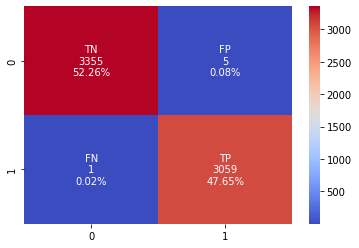

In [ ]:
print("*********************** Training Result ***********************")

pred_train_arr = model.predict(X_train)
pred_train = [np.argmax(val) for val in pred_train_arr]
accuracy_sc = accuracy_score(y_train, pred_train) * 100
print(f"Accuracy Score: {accuracy_sc:.2f}%")
precision_sc= precision_score(y_train, pred_train, average='weighted')*100
print(f"Precision Score: {precision_sc:.2f}%" )
recall_sc= recall_score(y_train, pred_train, average='weighted')*100
print(f"Recall Score: {recall_sc:.2f}%")
f1_sc= f1_score(y_train, pred_train, average='weighted')*100
print(f"F1 Score: {f1_sc:.2f}%")
cm_train= confusion_matrix(y_train, pred_train)  
print('Confusion matrix: \n')              
confusionMatrix(cm_train)


*********************** Testing Result ***********************
Accuracy Score: 90.42%
Precision Score: 91.40%
Recall Score: 90.42%
F1 Score: 90.32%
Confusion matrix: 



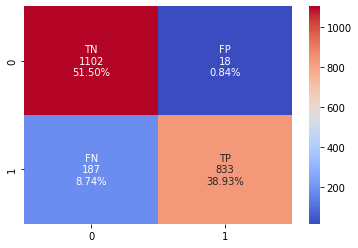

In [ ]:
print("*********************** Testing Result ***********************")  

pred_test_arr = model.predict(X_test)
pred_test = [np.argmax(val) for val in pred_test_arr]
accuracy_sc = accuracy_score(y_test, pred_test) * 100
print(f"Accuracy Score: {accuracy_sc:.2f}%")
precision_sc= precision_score(y_test, pred_test, average='weighted')*100
print(f"Precision Score: {precision_sc:.2f}%" )
recall_sc= recall_score(y_test, pred_test, average='weighted')*100
print(f"Recall Score: {recall_sc:.2f}%")
f1_sc= f1_score(y_test, pred_test, average='weighted')*100
print(f"F1 Score: {f1_sc:.2f}%" ) 
cm_test = confusion_matrix(y_test, pred_test)     
print('Confusion matrix: \n')              
confusionMatrix(cm_test)

**Exporting the trained model**

In [ ]:
model_name = 'fake_news_model_CovData'
path = F"/content/gdrive/My Drive/Group_Project_530/Models/{model_name}" 
model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Group_Project_530/Models/fake_news_model_CovData/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Group_Project_530/Models/fake_news_model_CovData/assets


## Loading trained model

In [ ]:
model_name = 'fake_news_model_CovData'
path = F"/content/gdrive/My Drive/Group_Project_530/Models/{model_name}" 
new_model = tf.keras.models.load_model(path, compile=False)

In [ ]:
text = ['indiafightscorona  deaths have been registered in the past  hours  of these are from  statesuts '] #Right fake
encoded_text = bert_encode(np.array(text), tokenizer, 100)
val = new_model.predict(encoded_text)
np.argmax(val)

0

In [ ]:
def tweet_prediction(tweet,model=new_model):
  encodedVal = bert_encode(np.array([tweet]), tokenizer, 100)
  pred_arr = model.predict(encodedVal)
  pred_val = np.argmax(pred_arr)
  if pred_val==1:
    return 'Fake'
  else:
    return 'Real'

In [ ]:
tweet_prediction('indiafightscorona  deaths have been registered in the past  hours  of these are from  statesuts ')

'Real'

## Super spreader identification

In [ ]:
import tweepy

consumer_key =  #ENTER KEY HERE AS A STRING 
consumer_secret =  #ENTER KEY HERE AS A STRING 
access_token =  #ENTER KEY HERE AS A STRING 
access_token_secret =  #ENTER KEY HERE AS A STRING 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
def superSpreaderCheck(tweet_df, user_df):

  value_counts_dict = dict(tweet_df.groupby('Label')['Label'].count())

  if 'Fake' in value_counts_dict.keys():
    fake_count= value_counts_dict['Fake']
  else:
    fake_count= 0

  size= int(len(tweet_df)/2)
  Influence_Score = float(user_df.Influence_Score)
  
  if(fake_count>=size and Influence_Score>=0.5):
    return True
  else:
    return False

In [ ]:
def get_user_data(user_ID, countOfTweets= 10):

  user_name = []
  num_followers = []
  num_following = []
  num_favorites= []
  num_retweets= []
  tweets_lst= []   

  try:
    tweets = api.user_timeline(screen_name= user_ID,count = countOfTweets)
  except tweepy.TweepError:              
    pass

  try:
    user_name_val= tweets[0].user.name
    user_name.append(user_name_val)

    user_followers= tweets[0].user.followers_count
    num_followers.append(user_followers) 

    user_friends= tweets[0].user.friends_count
    num_following.append(user_friends) 

  except tweepy.TweepError:              
        pass

  for tw in tweets:  
    try:
      tweets_new = api.get_status(tw.id)

      tweet_val = tweets_new.text
      tweets_lst.append(tweet_val)     

      user_likes = tweets_new.favorite_count
      num_favorites.append(user_likes) 

      user_retweets= tweets_new.retweet_count
      num_retweets.append(user_retweets) 

    except tweepy.TweepError:              
        pass

  userData = {
    'User_Name': user_name,  
    'NofFollowers': num_followers,
    'NofFollowing': num_following  
  }

  user_df= pd.DataFrame(userData)

  tweetData= {
    'Tweets': tweets_lst,
    'NofFavorites':  num_favorites,
    'NofRetweets': num_retweets
  }

  tweet_df= pd.DataFrame(tweetData)
  
  tweet_df['Label'] = tweet_df.Tweets.apply(lambda x: tweet_prediction(tweet=x))

  user_df["F2F_Ratio"] = user_df.NofFollowers/(user_df.NofFollowers+user_df.NofFollowing)

  user_df["Retweet_Ratio"] = sum(tweet_df.NofRetweets)/(sum(tweet_df.NofRetweets)+countOfTweets)

  user_df["Favorites_Ratio"] = sum(tweet_df.NofFavorites)/(sum(tweet_df.NofFavorites)+countOfTweets)

  user_df["Influence_Score"] = (user_df.F2F_Ratio + user_df.Retweet_Ratio + user_df.Favorites_Ratio)/3

  superSpreader = superSpreaderCheck(tweet_df, user_df)
  
  return tweet_df, user_df, superSpreader

In [ ]:
tweet_df, user_df, superSpreader = get_user_data('BorisJohnson', countOfTweets= 50)

In [ ]:
user_df

,User_Name,NofFollowers,NofFollowing,F2F_Ratio,Retweet_Ratio,Favorites_Ratio,Influence_Score
0,Boris Johnson,4418773,459,0.999896,0.998774,0.999799,0.99949


In [ ]:
tweet_df

,Tweets,NofFavorites,NofRetweets,Label
0,The UK has a long history of providing refuge ...,1383,270,Real
1,Thank you for your leadership and support as w...,1927,278,Real
2,The signing of new security declarations with ...,3578,535,Real
3,The security declaration I signed with Preside...,13746,1281,Real
4,Today we made history by signing a joint decla...,8817,960,Real
5,"Sharing more intelligence, bolstering military...",6243,807,Real
6,Thinking of the people of Manchester and those...,1761,235,Real
7,RT @BorisJohnson: Thank you for sharing your p...,0,512,Real
8,Thank you for sharing your priorities with me....,2873,512,Real
9,RT @10DowningStreet: The Prime Minister hosted...,0,244,Real


In [ ]:
superSpreader

False

In [ ]:
user_id = ['CNNBRK', 'bbcbreaking', 'nytimes',
           'elonmusk', 'JeffBezos',
           'britneyspears', 'jtimberlake','taylorswift13',
           'Cristiano', 'HKane', 
           'narendramodi',  'JoeBiden','BorisJohnson',
           'EmmaWatson', 'LeoDiCaprio',
           'livuninews', 'amazon',
           'shtbrns', 'DannyLo97768522', 'Arianah2019']

In [ ]:
superspreader_lst= []
inf_scores= []

for usr in user_id:
  tweet_df_val, user_df_val, superSpreader_val = get_user_data(usr, countOfTweets= 50)
  superspreader_lst.append(superSpreader_val)
  inf_scores.append(user_df_val.Influence_Score[0])

In [ ]:
infData = {
    'User_Name': user_id,  
    'Influence_Score': inf_scores,
    'Super_Spreader': superspreader_lst  
  }

inf_df= pd.DataFrame(infData)
inf_df

,User_Name,Influence_Score,Super_Spreader
0,CNNBRK,0.997796,False
1,bbcbreaking,0.999364,True
2,nytimes,0.997828,False
3,elonmusk,0.999841,False
4,JeffBezos,0.999749,False
5,britneyspears,0.997794,False
6,jtimberlake,0.999727,False
7,taylorswift13,0.999994,False
8,Cristiano,0.999986,False
9,HKane,0.999688,False
